# Run bias comparison

#### Load libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse as sps

In [2]:
from Data_manager.DataReader_ImportAll import *
import multiprocessing, traceback, os
from functools import  partial
# TODO ADDED
import skopt
import datetime, time
# TODO /ADDED

from ParameterTuning.SearchAbstractClass import SearchInputRecommenderParameters
from ParameterTuning.run_parameter_search import runParameterSearch_Content, runParameterSearch_Collaborative
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.DataSplitter_leave_k_out import DataSplitter_leave_k_out

from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender


In [3]:
dataset_class = Movielens1MReader # Movielens10MReader # CiteULike_aReader
feature_weighting = "none" # "TF-IDF" # "BM25" # 
allow_bias_ICM = False # True #
#ICM_bias = None

In [4]:
similarity_type_list = ["cosine"]

output_folder = "result_experiments/{}".format(dataset_class.DATASET_SUBFOLDER)
if allow_bias_ICM:
    output_folder += "ICM_bias/"
else:
    output_folder += "ICM_original/"
output_folder += "feature_weighting_"+feature_weighting+"/"

dataSplitter = DataSplitter_leave_k_out(dataset_class(), k_value=1, validation_set=True)
dataSplitter.load_data()

all_available_ICM_names = dataSplitter.get_loaded_ICM_names()

print("Available ICM: ", all_available_ICM_names)

ICM_name = all_available_ICM_names[0]


DataSplitter_leave_k_out: Cold users not allowed
DataSplitter_k_fold for DataReader: Movielens1M
	 Num items: 3882
	 Num users: 6039
 	 Train interactions: 986002, density: 4.21E-02
 	 Test interactions: 6039, density: 2.58E-04
	 Validation interactions: 6039, density: 2.58E-04



	 Statistics for ICM_genres: n_features 18, feature occurrences 6405, density: 9.17E-02


DataSplitter_k_fold: Done.
Available ICM:  ['ICM_genres']


In [5]:
print("Processing ICM: '{}'".format(ICM_name))

dataset_object = dataset_class(ICM_to_load_list = [ICM_name])

dataSplitter = DataSplitter_leave_k_out(dataset_object, k_value=1, validation_set=True)
dataSplitter.load_data()

ICM_object = dataSplitter.get_ICM_from_name(ICM_name)

Processing ICM: 'ICM_genres'
DataSplitter_leave_k_out: Cold users not allowed
DataSplitter_k_fold for DataReader: Movielens1M
	 Num items: 3882
	 Num users: 6039
 	 Train interactions: 986002, density: 4.21E-02
 	 Test interactions: 6039, density: 2.58E-04
	 Validation interactions: 6039, density: 2.58E-04



	 Statistics for ICM_genres: n_features 18, feature occurrences 6405, density: 9.17E-02


DataSplitter_k_fold: Done.


In [6]:
ICM_object
np.unique(ICM_object.data) # NB: 0 always included, cause ICM is sparse

array([1.])

In [7]:
URM_train, URM_validation, URM_test = dataSplitter.get_holdout_split()

In [8]:
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[5, 10, 15, 20, 25, 30])

End setup, init recommend

In [23]:
n_tests = 20
ICM_bias_min = 0 # min(0, np.min(ICM_object.data))
ICM_bias_max = 2 # np.max(ICM_object.data)

cutoff = 10
valid_results_MAP_at_cutoff = []
test_results_MAP_at_cutoff = []

ICM_bias_arr = np.linspace(0, ICM_bias_max, n_tests)

for ICM_bias in ICM_bias_arr:
    recommender_class = ItemKNNCBFRecommender
    recommender_parameters = SearchInputRecommenderParameters(
        CONSTRUCTOR_POSITIONAL_ARGS = [ICM_object, URM_train],
        CONSTRUCTOR_KEYWORD_ARGS = {},
        FIT_POSITIONAL_ARGS = [],
        FIT_KEYWORD_ARGS = {
            'topK': 50,
            'shrink': 100, 
            'similarity': 'cosine',
            'normalize': True,
            'feature_weighting': feature_weighting,
            'ICM_bias': ICM_bias,
            #**similarity_args
        }
    )
    
    print("ICM_bias: {}".format(ICM_bias))
    
    start_time = time.time()

    # Construct a new recommender instance
    recommender_instance = recommender_class(*recommender_parameters.CONSTRUCTOR_POSITIONAL_ARGS,
                                             **recommender_parameters.CONSTRUCTOR_KEYWORD_ARGS)

    recommender_instance.fit(*recommender_parameters.FIT_POSITIONAL_ARGS,
                             **recommender_parameters.FIT_KEYWORD_ARGS)
    #                          **current_fit_parameters,
    #                          **self.hyperparams_single_value)

    train_time = time.time() - start_time
    start_time = time.time()

    # Evaluate recommender and get results for the first cutoff
    evaluation_result_dict, evaluation_result_string = evaluator_validation.evaluateRecommender(recommender_instance)
    #evaluation_result_dict = evaluation_result_dict[list(evaluation_result_dict.keys())[0]]

    evaluation_time = time.time() - start_time

    # Evaluate recommender and get results for the first cutoff
    test_result_dict, test_result_string = evaluator_test.evaluateRecommender(recommender_instance)
    #test_result_dict = test_result_dict[list(test_result_dict.keys())[0]]

    test_time = time.time() - start_time

    # result MAP
    valid_MAP_at_cutoff = evaluation_result_dict[cutoff]['MAP']
    test_MAP_at_cutoff = test_result_dict[cutoff]['MAP']

    print('Train time: ', train_time)
    # print()
    print('Validation time: ', evaluation_time)
    # print('Validation result:', evaluation_result_string)
    print("Valid MAP@{}: {}".format(cutoff, valid_MAP_at_cutoff))
    print('Test time: ', test_time)
    # print('Test result:', test_result_string)
    print("Test MAP@{}: {}".format(cutoff, test_MAP_at_cutoff))
    print()
        
    valid_results_MAP_at_cutoff.append(valid_MAP_at_cutoff)
    test_results_MAP_at_cutoff.append(test_MAP_at_cutoff)

ICM_bias: 0.0
Similarity column 3882 ( 100 % ), 5923.49 column/sec, elapsed time 0.01 min
EvaluatorHoldout: Processed 6039 ( 100.00% ) in 5.53 seconds. Users per second: 1092
EvaluatorHoldout: Processed 6039 ( 100.00% ) in 25.91 seconds. Users per second: 233
Train time:  0.7124190330505371
Validation time:  5.5453269481658936
Valid MAP@10: 0.010348344228125665
Test time:  31.481015920639038
Test MAP@10: 0.009980759980759993

ICM_bias: 0.10526315789473684
Similarity column 3882 ( 100 % ), 6184.51 column/sec, elapsed time 0.01 min
EvaluatorHoldout: Processed 6039 ( 100.00% ) in 6.87 seconds. Users per second: 879
EvaluatorHoldout: Processed 6039 ( 100.00% ) in 23.77 seconds. Users per second: 254
Train time:  0.6723570823669434
Validation time:  6.92483115196228
Valid MAP@10: 0.010528456566707946
Test time:  30.710914850234985
Test MAP@10: 0.010125454387749483

ICM_bias: 0.21052631578947367
Similarity column 3882 ( 100 % ), 6234.37 column/sec, elapsed time 0.01 min
EvaluatorHoldout: Pro

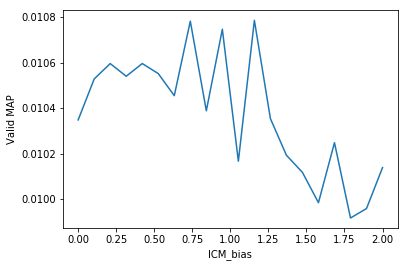

In [24]:
# plt.bar(np.arange(len(valid_results_MAP_at_cutoff)), valid_results_MAP_at_cutoff, align='center')
# plt.xticks(np.arange(len(valid_results_MAP_at_cutoff)), ICM_bias_arr)
plt.plot(ICM_bias_arr, valid_results_MAP_at_cutoff)
plt.ylabel('Valid MAP')
plt.xlabel('ICM_bias')
plt.show()

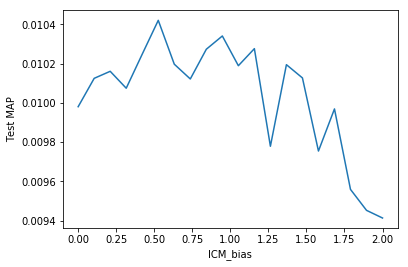

In [25]:
# plt.bar(np.arange(len(test_results_MAP_at_cutoff)), test_results_MAP_at_cutoff, align='center')
# plt.xticks(np.arange(len(test_results_MAP_at_cutoff)), ICM_bias_arr)
plt.plot(ICM_bias_arr, test_results_MAP_at_cutoff)
plt.ylabel('Test MAP')
plt.xlabel('ICM_bias')
plt.show()

Seems to give benefits.

Notice that large part of curve is above value at 0 (no bias).

Notices also that peaks are within 0-1 (ICM is indeed in 0-1)

TODO: repeat analysis around the best params taken from main runs